In [28]:
# Load libraries
import pandas as pd
import numpy as np
# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
# Data Processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import chi2
# Test / Train
from sklearn.model_selection import train_test_split
# Model selection libraries
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
# Model Search
from sklearn.model_selection import GridSearchCV
# Model Type
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

## Import Files

In [29]:
# Read csv file
employee_df = pd.read_csv('data/project/ibm_employee_train.csv')

In [30]:
# Combine test and train to resample
employee_test = pd.read_csv('data/project/ibm_employee_test.csv')

employee_df = employee_df.append(employee_test, ignore_index=True)

In [4]:
employee_df.shape

(1470, 35)

In [31]:
employee_df[['EmployeeCount','EmployeeNumber', 'Over18','StandardHours']].head()

,EmployeeCount,EmployeeNumber,Over18,StandardHours
0,1,1,Y,80
1,1,2,Y,80
2,1,4,Y,80
3,1,5,Y,80
4,1,7,Y,80


In [19]:
employee_df[['EmployeeCount','EmployeeNumber', 'Over18','StandardHours']].describe()

,EmployeeCount,EmployeeNumber,StandardHours
count,1470.0,1470.000000,1470.0
mean,1.0,1024.865306,80.0
std,0.0,602.024335,0.0
min,1.0,1.000000,80.0
25%,1.0,491.250000,80.0
50%,1.0,1020.500000,80.0
75%,1.0,1555.750000,80.0
max,1.0,2068.000000,80.0


Text(0, 0.5, 'Job Satisfaction (1-4)')

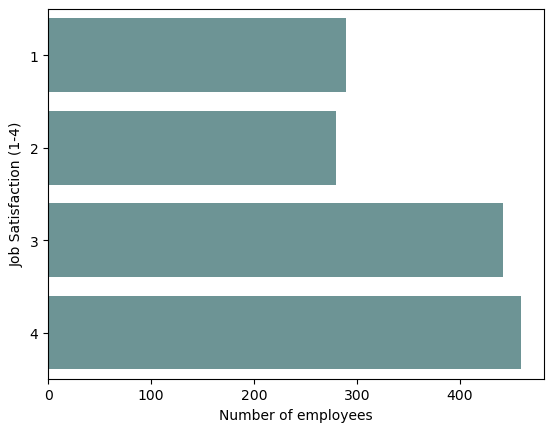

In [636]:
# View distribution of job satisfaction score
sns.countplot(data=employee_df, y="JobSatisfaction", color='#679B9B')
plt.xlabel('Number of employees')
plt.ylabel('Job Satisfaction (1-4)')

Text(0, 0.5, 'Performance Rating (1-4)')

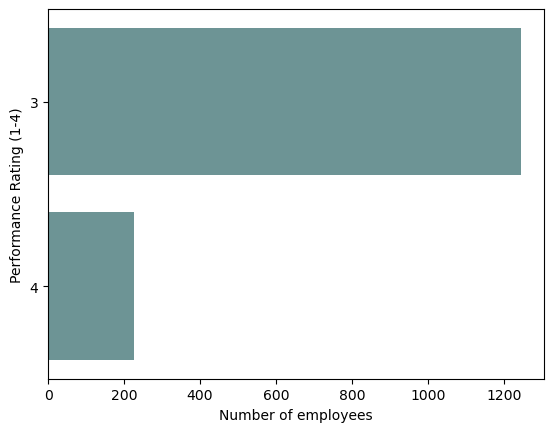

In [637]:
# View distribution of job satisfaction score
sns.countplot(data=employee_df, y="PerformanceRating", color='#679B9B')
plt.xlabel('Number of employees')
plt.ylabel('Performance Rating (1-4)')

In [4]:
# Remove columns with one value or not consistent
employee_df.drop(['Attrition','EmployeeCount','EmployeeNumber','Over18','StandardHours'], axis=1, inplace=True)

## Correlation

<AxesSubplot:>

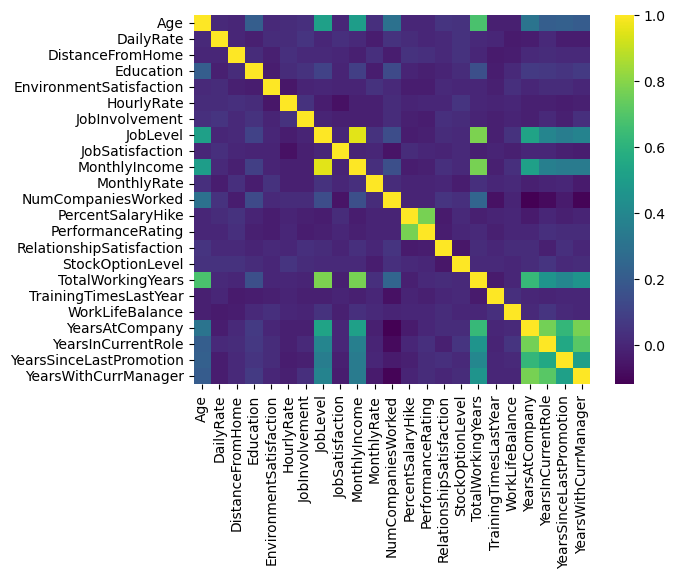

In [205]:
matrix = employee_df.corr().round(2)
sns.heatmap(matrix, cmap="viridis")

In [5]:
matrix = employee_df[['DailyRate', 'HourlyRate', 'MonthlyRate', 'MonthlyIncome']].corr().round(2)
matrix

,DailyRate,HourlyRate,MonthlyRate,MonthlyIncome
DailyRate,1.00,0.02,-0.03,0.01
HourlyRate,0.02,1.00,-0.02,-0.02
MonthlyRate,-0.03,-0.02,1.00,0.03
MonthlyIncome,0.01,-0.02,0.03,1.00


In [6]:
# Remove features with high correlation to another
employee_df.drop(['Age', 'YearsSinceLastPromotion', 'YearsInCurrentRole', 'YearsWithCurrManager'], axis=1, inplace=True)

In [614]:
corr = employee_df.corrwith(employee_df.JobSatisfaction)

In [615]:
print(corr.sort_values())

HourlyRate                 -0.071335
NumCompaniesWorked         -0.055699
JobInvolvement             -0.021476
TotalWorkingYears          -0.020185
WorkLifeBalance            -0.019459
RelationshipSatisfaction   -0.012454
Education                  -0.011296
MonthlyIncome              -0.007157
EnvironmentSatisfaction    -0.006784
TrainingTimesLastYear      -0.005779
YearsAtCompany             -0.003803
DistanceFromHome           -0.003669
JobLevel                   -0.001944
MonthlyRate                 0.000644
PerformanceRating           0.002297
StockOptionLevel            0.010690
PercentSalaryHike           0.020002
DailyRate                   0.030571
JobSatisfaction             1.000000
dtype: float64


## Encoder

In [8]:
# Seperate numeric and categorical features
df_numerical_features = employee_df.select_dtypes(include='number')
df_categorical_features = employee_df.select_dtypes(include='object')

In [11]:
enc = OrdinalEncoder()
X_enc = enc.fit_transform(df_categorical_features)

In [12]:
# Combine data
df_merged = pd.concat([df_numerical_features, df_categorical_features], axis=1)

In [13]:
df_merged[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime']] = pd.DataFrame(X_enc, columns=['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'])

In [14]:
top_perform = df_merged["JobSatisfaction"][df_merged['PerformanceRating']>3].replace({1:1, 2:2, 3:0, 4:0})

In [15]:
mid_perfom = df_merged["JobSatisfaction"][df_merged['PerformanceRating']<=3].replace({1:2, 2:2, 3:0, 4:0})

In [16]:
df_merged["JobSatisfaction"] = pd.concat([top_perform, mid_perfom])

## Split Test/Train

In [17]:
# features
features = df_merged[['DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 
                      'MonthlyRate', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'Gender',
                      'OverTime']]
# target
target = df_merged['JobSatisfaction']

In [18]:
train_X, test_X, train_y, test_y = train_test_split(
    features, target, random_state=49, shuffle=True , test_size=0.4)

In [19]:
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(train_X,train_y)

## Chi Square Test

In [162]:
scores, pvalues = chi2(X_res, y_res)
pvalues=["{0:.7f}".format(x)for x in pvalues]
i = 0
for column in X_res:
    print(column + ": " + pvalues[i])
    i += 1

DailyRate: 0.0000000
DistanceFromHome: 0.0000000
Education: 0.0016198
EnvironmentSatisfaction: 0.0000354
HourlyRate: 0.0000000
JobInvolvement: 0.0011726
JobLevel: 0.0000353
MonthlyRate: 0.0000000
PercentSalaryHike: 0.0000000
RelationshipSatisfaction: 0.0000001
StockOptionLevel: 0.0000006
TotalWorkingYears: 0.0000000
Gender: 0.0239440
OverTime: 0.0044031


## GridSearchCV

In [20]:
# Create a base classifier
model = LogisticRegression(max_iter=1000, multi_class='multinomial')

In [21]:
# Create a pipeline with a placeholder classifier
pipe = Pipeline([('scaler', MinMaxScaler(feature_range = (0, 1))), ('classifier', model)])

In [22]:
# Check performance of logisitic regression
search_space = [{"classifier": [LogisticRegression()],                
                 "classifier__multi_class": ['multinomial'],                            
                 "classifier__max_iter": [1000],
                 "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100]}]

In [172]:
# Check performance of random forest
search_space = [{"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [100, 200, 300, 1000]}]

In [178]:
# Create search space
search_space = [{"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": range(1,11),
                 "classifier__n_jobs": [-1]}]

In [184]:
# Create search space
search_space = [{"classifier": [DecisionTreeClassifier()],
                 "classifier__criterion":['gini','entropy'],
                 "classifier__max_depth": np.arange(3, 15)}]

In [191]:
search_space = [{"classifier": [XGBClassifier()],
                'classifier__max_depth': [3, 4, 5],
                'classifier__learning_rate': [0.1, 0.2, 0.3],
                'classifier__n_estimators': [50, 100, 150]
                }]

In [23]:
# Create grid search with 3 folds using classifiers
classifier = GridSearchCV(pipe, search_space, cv=3, verbose=0)

### Parameter Search

In [24]:
# Fit data to best hyperparameters
classifier.fit(X_res, y_res)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             param_grid=[{'classifier': [LogisticRegression(C=100,
                                                            max_iter=1000,
                                                            multi_class='multinomial')],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__max_iter': [1000],
                          'classifier__multi_class': ['multinomial']}])

In [25]:
# Best model parameters
classifier.best_params_

{'classifier': LogisticRegression(C=100, max_iter=1000, multi_class='multinomial'),
 'classifier__C': 100,
 'classifier__max_iter': 1000,
 'classifier__multi_class': 'multinomial'}

In [26]:
classifier.best_score_

0.6720333929636255

## Model Evaluation

In [170]:
def ModelEvaluation(model):
    # Create a pipeline
    pipe = Pipeline([('scaler', MinMaxScaler(feature_range = (0, 1))), ('classifier', model)])
    
    # Fit SMOTE dataset to chosen model type
    pipe.fit(X_res, y_res)
    
    # Accuracy Score
    print('Accuracy Score')
    print(pipe.score(test_X, test_y), '\n')
    
    # Train model and make predictions
    target_predicted = pipe.predict(test_X)
    
    # Create confusion matrix
    matrix = confusion_matrix(test_y, target_predicted)

    # Relabel x and y labels
    # matrix_df = pd.DataFrame(matrix, range(1,5), range(1,5))

    # Plot heatmap of confusion matrix
    sns.heatmap(matrix, annot=True, cbar=None, cmap=plt.cm.Greens, fmt='g')
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()
    
    print('\n', classification_report(test_y, target_predicted), '\n\n')
    
    pred_prob = pipe.predict_proba(test_X)
    
    # 0.7 ≤ ROC < 0.8: Acceptable discrimination
    print('ROC AUC Score')
    print(roc_auc_score(test_y, pred_prob, multi_class='ovo'))

### Multinomial Logistic Regression Model

Accuracy Score
0.47278911564625853 



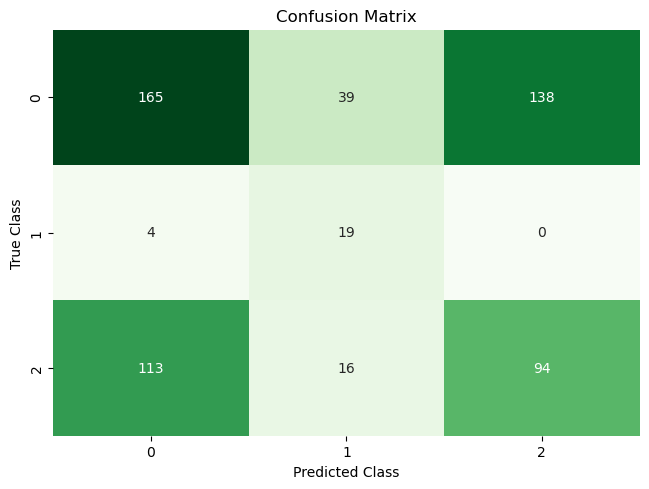


               precision    recall  f1-score   support

           0       0.59      0.48      0.53       342
           1       0.26      0.83      0.39        23
           2       0.41      0.42      0.41       223

    accuracy                           0.47       588
   macro avg       0.42      0.58      0.44       588
weighted avg       0.50      0.47      0.48       588
 


ROC AUC Score
0.7712823956731151


In [171]:
ModelEvaluation(LogisticRegression(C=100, max_iter=1000, multi_class='multinomial'))

### Random Forest Model

Accuracy Score
0.54421768707483 



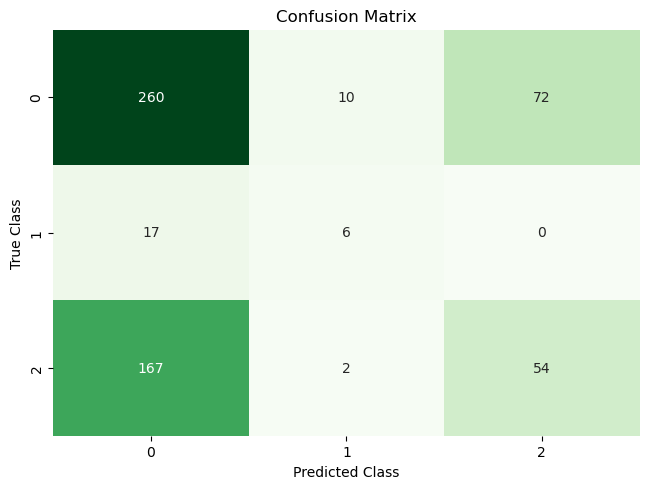


               precision    recall  f1-score   support

           0       0.59      0.76      0.66       342
           1       0.33      0.26      0.29        23
           2       0.43      0.24      0.31       223

    accuracy                           0.54       588
   macro avg       0.45      0.42      0.42       588
weighted avg       0.52      0.54      0.51       588
 


ROC AUC Score
0.759277217002125


In [177]:
ModelEvaluation(RandomForestClassifier(n_estimators=300))

### K Neighbors Classifier

Accuracy Score
0.49489795918367346 



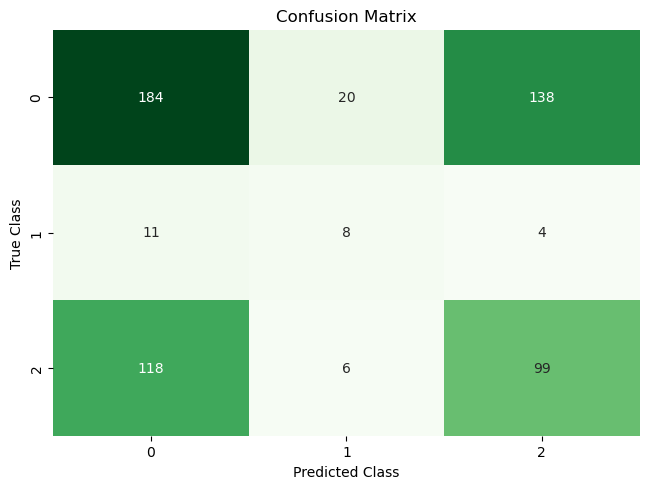


               precision    recall  f1-score   support

           0       0.59      0.54      0.56       342
           1       0.24      0.35      0.28        23
           2       0.41      0.44      0.43       223

    accuracy                           0.49       588
   macro avg       0.41      0.44      0.42       588
weighted avg       0.51      0.49      0.50       588
 


ROC AUC Score
0.5824459928009404


In [183]:
ModelEvaluation(KNeighborsClassifier(n_jobs=-1, n_neighbors=1))

### Decision Tree Classifier

Accuracy Score
0.4914965986394558 



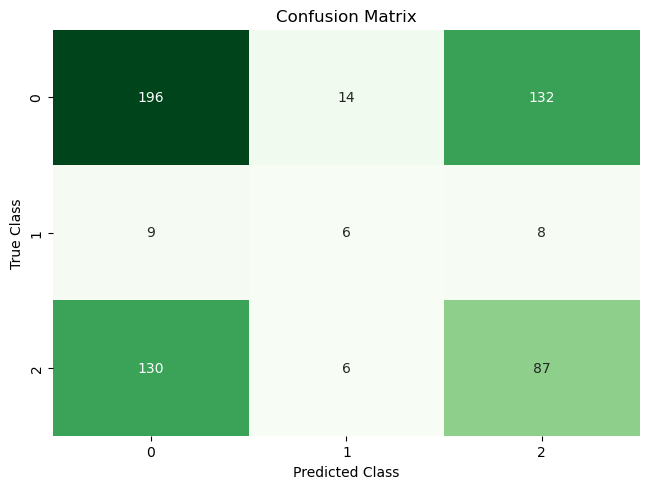


               precision    recall  f1-score   support

           0       0.59      0.57      0.58       342
           1       0.23      0.26      0.24        23
           2       0.38      0.39      0.39       223

    accuracy                           0.49       588
   macro avg       0.40      0.41      0.40       588
weighted avg       0.49      0.49      0.49       588
 


ROC AUC Score
0.5488648236131587


In [189]:
ModelEvaluation(DecisionTreeClassifier(criterion='gini', max_depth=12))

### XGBoost Classifier

Accuracy Score
0.5221088435374149 



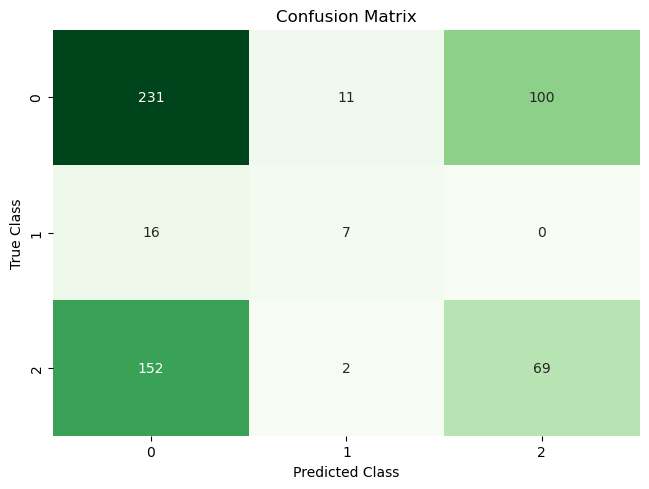


               precision    recall  f1-score   support

           0       0.58      0.68      0.62       342
           1       0.35      0.30      0.33        23
           2       0.41      0.31      0.35       223

    accuracy                           0.52       588
   macro avg       0.45      0.43      0.43       588
weighted avg       0.51      0.52      0.51       588
 


ROC AUC Score
0.7050570904199907


In [196]:
ModelEvaluation(XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=150))